In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('input/craigslistVehicles.csv')
df.drop(labels=['url', 'VIN', 'image_url', 'lat', 'long'], axis=1, inplace=True)

In [3]:
# Replace 'other' values to 'NaN' and convert value type to 'float' for feature 'cylinders'
df['cylinders'] = df['cylinders'].replace('other', np.NaN)
df['cylinders'] = df['cylinders'].apply(lambda num: float(num[0]) if type(num) == np.str else np.NaN)
# Age of car
df['age'] = 2019 - df.year
# Odometer from miles to kilometers
df['odometer_km'] = round(df.odometer / 1.609)
df.drop(labels=['odometer'], axis=1, inplace=True)
# Average price for manufacturer of car
price_list = []
for i in df.manufacturer.unique():
    if type(i)== str:
        price_list.append((i,int(df[df.manufacturer == i].price.mean())))
    else:
        price_list.append((i,np.NaN))
price_list = dict(price_list)
df['avr_price'] = df.manufacturer.map(price_list)

In [4]:
# Drop the cars which cost more then 1 million
df.drop(df[df.price > 1e+5].index, inplace=True)
df.drop(df[df.price < 1e+2].index, inplace=True)
#
df.drop(df[df.manufacturer.isnull()].index, axis=0, inplace=True)
df.drop(df[df.make.isnull()].index, axis=0, inplace=True)

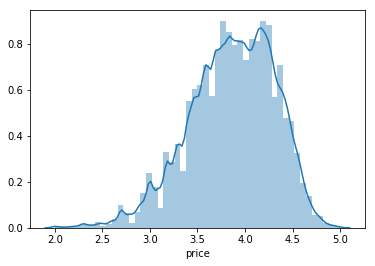

In [5]:
sns.distplot(np.log10(df.price));

In [6]:
bins = [0, 3e+3, 1e+4, 2e+4, 5e+4, 1e+6]
labels = ['cheap', 'quite cheap', 'medium', 'quite expensive', 'expensive']
df['price_cat'] = pd.cut(df['price'], bins=bins, labels=labels)

In [7]:
df = df[df.make.isin(df.make.value_counts()[df.make.value_counts() > 20].index)]

In [8]:
df.condition = df.groupby(['price_cat'])['condition'].apply(lambda x:x.fillna(x.value_counts().index.tolist()[0]))

In [9]:
for i in ['title_status', 'fuel', 'drive', 'cylinders', 'transmission', 'type', 'paint_color', 'size', 'odometer_km']:
    df[i] = df.groupby(['manufacturer'])[i].apply(lambda x:x.fillna(x.value_counts().index.tolist()[0]))

In [10]:
df['target'] = (df['price'] > 10000).astype('int')

In [11]:
df.to_csv('data.csv', index=False)

# Calculate entropy, Gini and IG

In [12]:
def entropy(array): # alarming: without Nan values!
    l = array.shape[0]
    S = 0
    for val in array.value_counts():
        S +=  -val/l * np.log2(val/l)
    return S

def gini(array):
    l = array.shape[0]
    S = 0
    for val in array.value_counts():
        S += (val/l)**2
    return (1 - S)

def IG(array1, array2, S0, metod):
    IG = S0
    N = array1.shape[0] + array2.shape[0]
    for array in [array1, array2]:
        IG -= metod(array) * array.shape[0] / N
    return IG

def split(dataframe, name_array, name_target, metod):
    data = dataframe[[name_array, name_target]].sort_values(by=name_array)
    array = data[name_array]
    array.index = [i for i in range(len(array))]
    target = data[name_target]
    target.index = [i for i in range(len(target))]

    best_result = [0, 0, 0] #  IG, entropy/gini (left, right)
    best_split = [[],[]]
    idx=0
    
    for i in range(array.shape[0]):
        if array[i]==array[idx]: #miss same values
            continue
        else:
            idx = i
            left = target[:i]
            right = target[i:]
            
            if IG(left, right, metod(array), metod) > best_result[0]:
                best_result[0] = IG(left, right, metod(array), metod)
                best_result[1] = metod(left)
                best_result[2] = metod(right)
                best_split[0] = left
                best_split[1] = right

    print('Best Information Gain =', round(best_result[0],4))
    print('Best measure of uncertainty for left =', round(best_result[1],4))
    print('Best measure of uncertainty for right =', round(best_result[2],4))
#     return best_split

In [13]:
for i in ['manufacturer', 'condition', 'cylinders', 'age']:
    print(i)
    split(df, i, 'target', gini)
    split(df, i, 'target', entropy)
    print()

manufacturer
Best Information Gain = 0.4367
Best measure of uncertainty for left = 0.477
Best measure of uncertainty for right = 0.3815
Best Information Gain = 3.1689
Best measure of uncertainty for left = 0.9666
Best measure of uncertainty for right = 0.8216

condition
Best Information Gain = 0.1219
Best measure of uncertainty for left = 0.4998
Best measure of uncertainty for right = 0.3378
Best Information Gain = 0.5642
Best measure of uncertainty for left = 0.9998
Best measure of uncertainty for right = 0.7513

cylinders
Best Information Gain = 0.2047
Best measure of uncertainty for left = 0.4447
Best measure of uncertainty for right = 0.4991
Best Information Gain = 0.7098
Best measure of uncertainty for left = 0.9186
Best measure of uncertainty for right = 0.9987

age
Best Information Gain = 0.6434
Best measure of uncertainty for left = 0.3567
Best measure of uncertainty for right = 0.2889
Best Information Gain = 4.1486
Best measure of uncertainty for left = 0.782
Best measure of u

# Train a decision tree (DecisionTreeClassifier, random_state = 17)

In [14]:
# Use One-Hot-Encoding for 'manufacturer'
df_tree = df[['manufacturer', 'cylinders', 'age', 'odometer_km']]
df_ohe = pd.concat([df_tree, pd.get_dummies(df_tree['manufacturer'], prefix="manufacturer")],
                     axis=1)
df_ohe.drop(labels=['manufacturer'], axis=1, inplace=True)

In [15]:
df_ohe.to_csv('data_ohe.csv', index=False)

In [16]:
df_ohe.columns

Index(['cylinders', 'age', 'odometer_km', 'manufacturer_acura',
       'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick',
       'manufacturer_cadillac', 'manufacturer_chevrolet',
       'manufacturer_chrysler', 'manufacturer_datsun', 'manufacturer_dodge',
       'manufacturer_fiat', 'manufacturer_ford', 'manufacturer_gmc',
       'manufacturer_harley-davidson', 'manufacturer_honda',
       'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar',
       'manufacturer_jeep', 'manufacturer_kia', 'manufacturer_land rover',
       'manufacturer_lexus', 'manufacturer_lincoln', 'manufacturer_mazda',
       'manufacturer_mercedes-benz', 'manufacturer_mercury',
       'manufacturer_mini', 'manufacturer_mitsubishi', 'manufacturer_nissan',
       'manufacturer_pontiac', 'manufacturer_ram', 'manufacturer_rover',
       'manufacturer_saturn', 'manufacturer_subaru', 'manufacturer_toyota',
       'manufacturer_volkswagen', 'manufacturer_volvo'],
      dtype='object')

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
tree = DecisionTreeClassifier(random_state=17)
tree.fit(X=df_ohe, y=df.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

# Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV)

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# tree params for grid search
tree_params = {'max_depth': np.arange(1, 20, 2)}
tree_grid = GridSearchCV(tree, tree_params, cv=5)

In [21]:
tree_grid.fit(X=df_ohe, y=df.target)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
tree_grid.best_score_, tree_grid.best_params_

(0.8584003408902602, {'max_depth': 17})

# Display final tree as an image

In [ ]:
# brew install graphviz # decide all problem

In [86]:
# couldn't make tree with best_params_
tree = DecisionTreeClassifier(random_state=17, max_depth=5)
tree.fit(X=df_ohe[['cylinders', 'age', 'odometer_km']], y=df.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [87]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree_grid.dot')
!dot -Tpng 'tree_grid.dot' -o 'tree_grid.png'

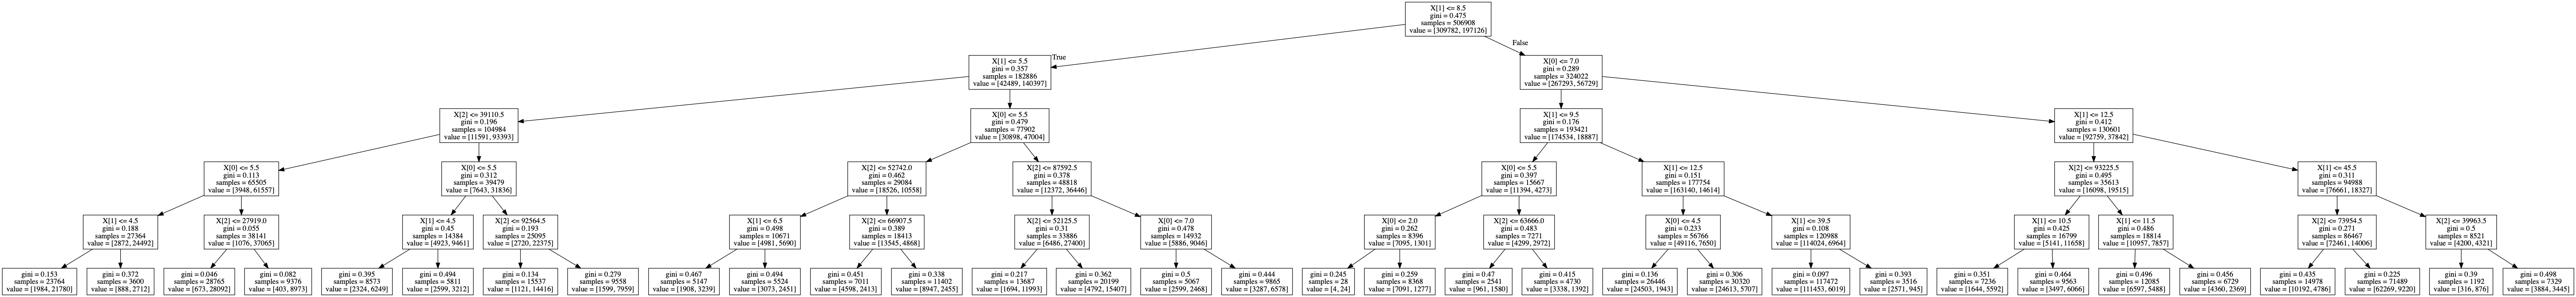

In [90]:
from IPython.display import Image
Image("tree_grid.png")
# <img src="output.png"> for marcdown